In [2]:
import pandas as pd

In [3]:
customers = pd.read_csv("data/customers_c.csv")
articles = pd.read_csv("data/articles_c.csv")
transactions = pd.read_csv("data/transactions_c.csv")

In [4]:
# 고객-거래-상품 조인
df = transactions.merge(customers, on="customer_id", how="inner")
df = df.merge(articles, on="article_id", how="inner")

print("결합 후 데이터 크기:", df.shape)
print(df.head())

결합 후 데이터 크기: (806906, 39)
        t_dat                                        customer_id  article_id  \
0  2019-11-05  3e2b60b679e62fb49516105b975560082922011dd752ec...   698328010   
1  2019-05-22  89647ac2274f54c770aaa4b326e0eea09610c252381f37...   760597002   
2  2019-05-10  2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...   488561032   
3  2019-08-26  7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...   682771001   
4  2019-08-10  3b77905de8b32045f08cedb79200cdfa477e9562429a39...   742400033   

      price  sales_channel_id  year  month    weekday sales_channel     FN  \
0  0.016932                 2  2019     11    Tuesday        Online   True   
1  0.033881                 2  2019      5  Wednesday        Online  False   
2  0.016932                 2  2019      5     Friday        Online   True   
3  0.033881                 2  2019      8     Monday        Online  False   
4  0.003220                 1  2019      8   Saturday       Offline  False   

   ...    department_nam

In [5]:
import pandas as pd

# 처리 전 크기
print("처리 전:", df.shape)

# 1) 연령 이상치 제거
df = df[(df["age"] >= 10) & (df["age"] <= 100)]

# 2) 가격 이상치 처리 (0원 제거)
df = df[df["price"] > 0]

# 3) 멤버십 상태 Null → Unknown
df["club_member_status"] = df["club_member_status"].fillna("Unknown")

# 4) 판매채널 1,2만 유지
df = df[df["sales_channel_id"].isin([1, 2])]

# 5) 날짜 처리
df["t_dat"] = pd.to_datetime(df["t_dat"])
df["year"] = df["t_dat"].dt.year
df["month"] = df["t_dat"].dt.month
df["weekday"] = df["t_dat"].dt.day_name()

# 6) 연령대 파생
df["age_group"] = (df["age"] // 10) * 10

# 처리 후 크기
print("처리 후:", df.shape)


처리 전: (806906, 39)
처리 후: (806906, 39)


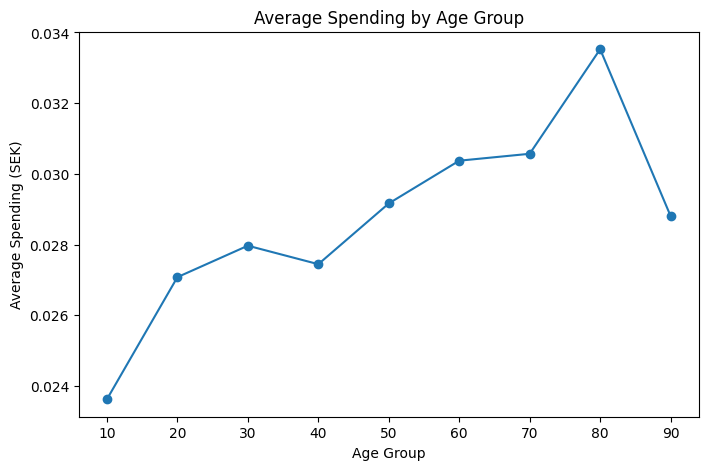

In [6]:
# 연령대 파생
df["age_group"] = (df["age"] // 10) * 10

# 연령대별 평균 구매액
age_sales = df.groupby("age_group")["price"].mean().reset_index()

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(age_sales["age_group"], age_sales["price"], marker="o")
plt.xlabel("Age Group")
plt.ylabel("Average Spending (SEK)")
plt.title("Average Spending by Age Group")
plt.show()

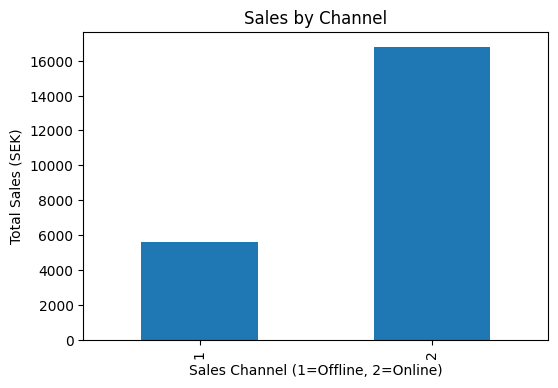

In [7]:
channel_sales = df.groupby("sales_channel_id")["price"].sum()

channel_sales.plot(kind="bar", title="Sales by Channel", figsize=(6,4))
plt.xlabel("Sales Channel (1=Offline, 2=Online)")
plt.ylabel("Total Sales (SEK)")
plt.show()

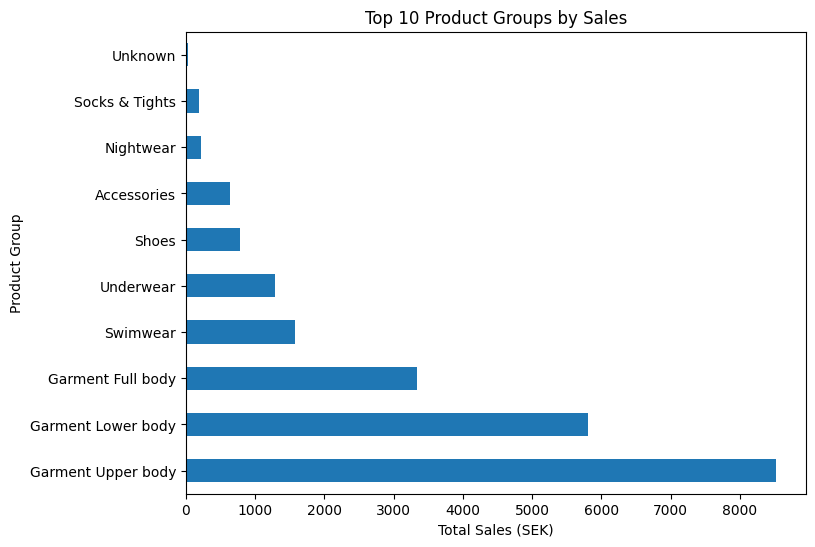

In [8]:
top_products = df.groupby("product_group_name")["price"].sum().nlargest(10)

top_products.plot(kind="barh", figsize=(8,6), title="Top 10 Product Groups by Sales")
plt.xlabel("Total Sales (SEK)")
plt.ylabel("Product Group")
plt.show()

In [9]:
df["age_group"] = (df["age"] // 10) * 10
age_sales = df.groupby("age_group")["price"].mean().reset_index()


# 고객수를  중복 제외 

In [10]:
age_customer_cnt = (
    df
    .groupby('age_group')['customer_id']
    .nunique()
    .sort_values(ascending=False)
)

print(age_customer_cnt)


age_group
20    145450
30     65876
50     60510
40     53078
60     15498
10      8676
70      2972
80       224
90        19
Name: customer_id, dtype: int64


In [11]:
age_customer_cnt = (
    df
    .groupby('age_group')['customer_id']
    .nunique()
    .sort_index()  # 인덱스 기준으로 오름차순 정렬
)

print(age_customer_cnt)


age_group
10      8676
20    145450
30     65876
40     53078
50     60510
60     15498
70      2972
80       224
90        19
Name: customer_id, dtype: int64


In [12]:
age_customer_ratio = age_customer_cnt / age_customer_cnt.sum()
print(age_customer_ratio)

age_group
10    0.024627
20    0.412855
30    0.186987
40    0.150660
50    0.171756
60    0.043991
70    0.008436
80    0.000636
90    0.000054
Name: customer_id, dtype: float64


In [13]:
age_customer_pct = (age_customer_ratio * 100).round(2)
print(age_customer_pct)

age_group
10     2.46
20    41.29
30    18.70
40    15.07
50    17.18
60     4.40
70     0.84
80     0.06
90     0.01
Name: customer_id, dtype: float64


In [14]:
# 윈도우 기본 한글 폰트
# 마이너스 깨짐 방지

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False     


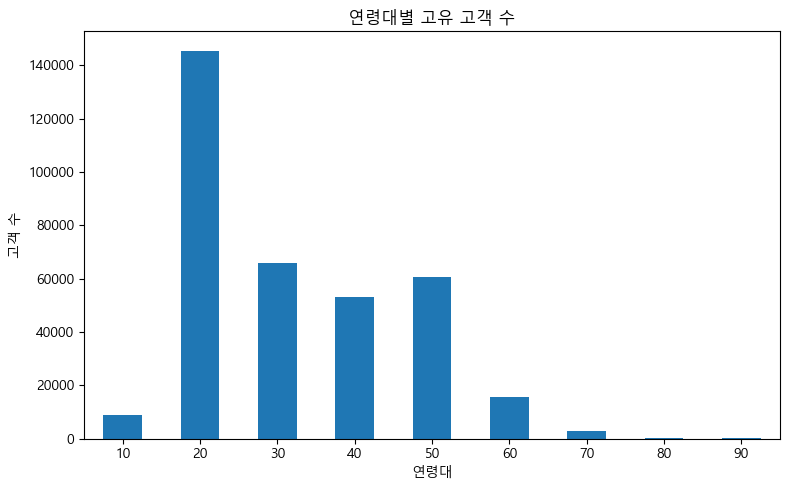

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
age_customer_cnt.plot(kind='bar')
plt.title('연령대별 고유 고객 수')
plt.xlabel('연령대')
plt.ylabel('고객 수')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

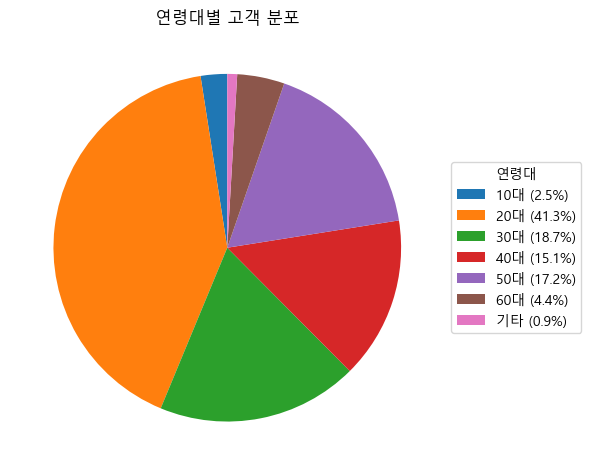

In [16]:
import matplotlib.pyplot as plt

# 퍼센트 계산
age_ratio_pct = age_customer_ratio * 100

# 기타 묶기 (2% 미만)
threshold = 2
small = age_ratio_pct < threshold
large = age_ratio_pct[~small]

other_sum = age_ratio_pct[small].sum()
age_ratio_grouped = large.copy()
age_ratio_grouped['기타'] = other_sum

# 라벨에 퍼센트 포함
labels = [
    f"{idx}대 ({val:.1f}%)"
    if idx != '기타' else f"기타 ({val:.1f}%)"
    for idx, val in age_ratio_grouped.items()
]

plt.figure(figsize=(6, 6))
wedges, _ = plt.pie(
    age_ratio_grouped,
    startangle=90
)

plt.title('연령대별 고객 분포')

# 범례 (색깔 설명)
plt.legend(
    wedges,
    labels,
    title="연령대",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


# 헥심 메출

In [17]:
age_customer_cnt = (
    df
    .groupby('age_group')['customer_id']
    .nunique()
    .sort_values(ascending=False)
    .sort_index() 
)

print(age_customer_cnt)

age_group
10      8676
20    145450
30     65876
40     53078
50     60510
60     15498
70      2972
80       224
90        19
Name: customer_id, dtype: int64


In [18]:
age_sales = (
    df
    .groupby('age_group')['price']
    .sum()
    .sort_values(ascending=False)
    .sort_index() 
)

print(age_sales)

age_group
10     323.260898
20    8934.391850
30    4602.777992
40    3453.656435
50    3941.972909
60     966.104049
70     167.452847
80      13.979847
90       1.065898
Name: price, dtype: float64


In [19]:
age_summary = (
    pd.concat([age_customer_cnt, age_sales], axis=1)
    .reset_index()
)

age_summary.columns = ['age_group', 'customer_cnt', 'total_sales']
age_summary


,age_group,customer_cnt,total_sales
0,10,8676,323.260898
1,20,145450,8934.391850
2,30,65876,4602.777992
3,40,53078,3453.656435
4,50,60510,3941.972909
5,60,15498,966.104049
6,70,2972,167.452847
7,80,224,13.979847
8,90,19,1.065898


In [20]:
age_summary['sales_per_customer'] = (
    age_summary['total_sales'] / age_summary['customer_cnt']
)
age_summary.sort_values('age_group', ascending=True)


,age_group,customer_cnt,total_sales,sales_per_customer
0,10,8676,323.260898,0.037259
1,20,145450,8934.391850,0.061426
2,30,65876,4602.777992,0.069870
3,40,53078,3453.656435,0.065068
4,50,60510,3941.972909,0.065146
5,60,15498,966.104049,0.062337
6,70,2972,167.452847,0.056343
7,80,224,13.979847,0.062410
8,90,19,1.065898,0.056100


In [21]:
age_summary['total_sales'] = age_summary['total_sales'].round(4)

age_summary['sales_per_customer'] = (
    age_summary['total_sales'] / age_summary['customer_cnt']
).round(4)

age_summary = age_summary.sort_values('age_group', ascending=True)
# age_summary = age_summary.sort_values('total_sales', ascending=False)
age_summary


,age_group,customer_cnt,total_sales,sales_per_customer
0,10,8676,323.2609,0.0373
1,20,145450,8934.3918,0.0614
2,30,65876,4602.7780,0.0699
3,40,53078,3453.6564,0.0651
4,50,60510,3941.9729,0.0651
5,60,15498,966.1040,0.0623
6,70,2972,167.4528,0.0563
7,80,224,13.9798,0.0624
8,90,19,1.0659,0.0561


In [22]:
age_summary['total_sales_index'] = (
    age_summary['total_sales'] * 100
).round(2)

age_summary['sales_per_customer_index'] = (
    age_summary['sales_per_customer'] * 100
).round(2)

age_summary = age_summary.sort_values('total_sales_index', ascending=False)
age_summary


,age_group,customer_cnt,total_sales,sales_per_customer,total_sales_index,sales_per_customer_index
1,20,145450,8934.3918,0.0614,893439.18,6.14
2,30,65876,4602.7780,0.0699,460277.80,6.99
4,50,60510,3941.9729,0.0651,394197.29,6.51
3,40,53078,3453.6564,0.0651,345365.64,6.51
5,60,15498,966.1040,0.0623,96610.40,6.23
0,10,8676,323.2609,0.0373,32326.09,3.73
6,70,2972,167.4528,0.0563,16745.28,5.63
7,80,224,13.9798,0.0624,1397.98,6.24
8,90,19,1.0659,0.0561,106.59,5.61


In [23]:
# 총매출
# 비율
age_sales_ratio = age_sales / age_sales.sum()
print(age_sales_ratio)


age_group
10    0.014428
20    0.398774
30    0.205438
40    0.154149
50    0.175944
60    0.043121
70    0.007474
80    0.000624
90    0.000048
Name: price, dtype: float64


In [24]:
age_sales = (
    df
    .groupby('age_group')['price']
    .sum()
    .sort_values(ascending=False)
    .sort_index()
)

print(age_sales)


age_group
10     323.260898
20    8934.391850
30    4602.777992
40    3453.656435
50    3941.972909
60     966.104049
70     167.452847
80      13.979847
90       1.065898
Name: price, dtype: float64


In [25]:
# 총매출액 + 고객 수
# 연령대별 총매출액과 고객 수 계산
age_summary_simple = (
    df
    .groupby('age_group')
    .agg(
        total_sales=('price', 'sum'),        # 총 매출액 (정규화된 값)
        customer_cnt=('customer_id', 'nunique')  # 고객 수
    )
)

# 소수점 정리
age_summary_simple = age_summary_simple.round(3)

# 총매출액 기준 내림차순 정렬
age_summary_simple = age_summary_simple.sort_values('age_group', ascending=True)

# 결과 출력
print(age_summary_simple)


           total_sales  customer_cnt
age_group                           
10             323.261          8676
20            8934.392        145450
30            4602.778         65876
40            3453.656         53078
50            3941.973         60510
60             966.104         15498
70             167.453          2972
80              13.980           224
90               1.066            19


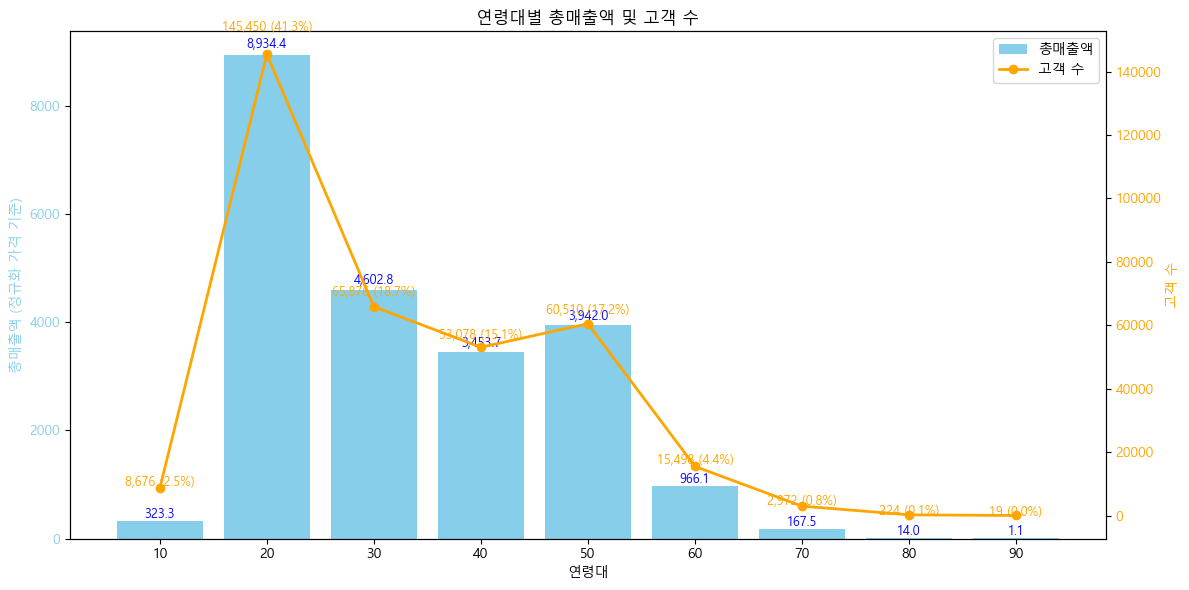

In [26]:
import matplotlib.pyplot as plt

# 연령대별 총매출액과 고객 수 계산
age_summary = (
    df
    .groupby('age_group')
    .agg(
        total_sales=('price', 'sum'),
        customer_cnt=('customer_id', 'nunique')
    )
)

# 고객 수 비율 계산
customer_ratio = age_summary['customer_cnt'] / age_summary['customer_cnt'].sum() * 100

# 총매출액 기준 내림차순 정렬
age_summary = age_summary.sort_values('age_group', ascending=True)
age_order = age_summary.index.tolist()
x_labels = [str(age) for age in age_order]

fig, ax1 = plt.subplots(figsize=(12,6))

# 총매출액 막대그래프
bars = ax1.bar(x_labels, age_summary['total_sales'], color='skyblue', label='총매출액')
ax1.set_xlabel('연령대')
ax1.set_ylabel('총매출액 (정규화 가격 기준)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# 총매출액 숫자 표시 (막대 위)
for bar, sales in zip(bars, age_summary['total_sales']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
             f'{sales:,.1f}', ha='center', va='bottom', fontsize=9, color='blue')

# 고객 수 라인그래프
ax2 = ax1.twinx()
ax2.plot(x_labels, age_summary['customer_cnt'], color='orange', marker='o', linestyle='-', linewidth=2, label='고객 수')
ax2.set_ylabel('고객 수', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 고객 수 숫자 + 퍼센트 표시 (총매출액보다 더 위)
for i, (cnt, pct) in enumerate(zip(age_summary['customer_cnt'], customer_ratio.reindex(age_order))):
    ax2.text(i, cnt + cnt*0.05 + age_summary['total_sales'].max()*0.01,
             f'{cnt:,} ({pct:.1f}%)', color='orange', ha='center', fontsize=9)

# 범례
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper right')

plt.title('연령대별 총매출액 및 고객 수')
fig.tight_layout()
plt.show()


# 연령대별로 많이 산 상품 

In [27]:
# 1️⃣ 연령대별 상품별 구매 횟수 계산
age_article_cnt = df.groupby(['age_group', 'article_id']).size().reset_index(name='purchase_cnt')

# 2️⃣ 연령대별 TOP 5 상품 선택
top5_articles_by_age = (
    age_article_cnt
    .sort_values(['age_group', 'purchase_cnt'], ascending=[True, False])
    .groupby('age_group')
    .head(5)
)

# 3️⃣ 연령대별로 묶어서 출력
top5_articles_by_age.reset_index(drop=True, inplace=True)

# 보기 좋게 연령대별로 묶어서 출력
for age in sorted(top5_articles_by_age['age_group'].unique()):
    temp = top5_articles_by_age[top5_articles_by_age['age_group'] == age]
    print(f"\n=== {age}대 인기 상품 TOP 5 ===")
    print(temp[['article_id', 'purchase_cnt']].reset_index(drop=True))



=== 10대 인기 상품 TOP 5 ===
   article_id  purchase_cnt
0   706016001            60
1   759871002            48
2   706016002            43
3   684209004            27
4   685814003            25

=== 20대 인기 상품 TOP 5 ===
   article_id  purchase_cnt
0   706016001           776
1   706016002           581
2   156231001           367
3   759871002           367
4   464297007           358

=== 30대 인기 상품 TOP 5 ===
   article_id  purchase_cnt
0   706016001           187
1   562245001           142
2   464297007           135
3   158340001           131
4   160442007           131

=== 40대 인기 상품 TOP 5 ===
   article_id  purchase_cnt
0   706016001           189
1   706016002           182
2   673677002           114
3   351484002           106
4   372860001           103

=== 50대 인기 상품 TOP 5 ===
   article_id  purchase_cnt
0   706016001           188
1   706016002           174
2   568601006           145
3   573716012           135
4   372860001           127

=== 60대 인기 상품 TOP 5 ===
   article

In [28]:
# 연령대별 상품별 구매 횟수 계산
age_article_cnt = df.groupby(['age_group', 'article_id']).size().reset_index(name='purchase_cnt')

# 연령대별 TOP 5 상품 선택
top5_articles_by_age = (
    age_article_cnt
    .sort_values(['age_group', 'purchase_cnt'], ascending=[True, False])
    .groupby('age_group')
    .head(5)
)


In [29]:
# # 연령대 순서 정의
# age_order = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# # 1️⃣ 연령대별 상품별 구매 횟수 계산
# age_article_cnt = df.groupby(['age_group', 'article_id']).size().reset_index(name='purchase_cnt')

# # 2️⃣ 연령대별 TOP 5 상품 선택
# top5_articles_by_age = (
#     age_article_cnt
#     .sort_values(['age_group', 'purchase_cnt'], ascending=[True, False])
#     .groupby('age_group')
#     .head(5)
# )

# # 3️⃣ articles와 합쳐서 상품명, 상품 종류 추가
# top5_with_info = top5_articles_by_age.merge(
#     articles[['article_id', 'prod_name', 'product_type_name']], 
#     on='article_id', 
#     how='left'
# )

# # 4️⃣ 연령대 순서 맞추기
# top5_with_info['age_group'] = pd.Categorical(top5_with_info['age_group'], categories=age_order, ordered=True)
# top5_with_info = top5_with_info.sort_values(['age_group', 'purchase_cnt'], ascending=[True, False])

# # 5️⃣ 연령대별로 보기 좋게 출력
# for age in age_order:
#     temp = top5_with_info[top5_with_info['age_group'] == age]
#     if temp.empty:
#         print(f"\n=== {age}대 인기 상품 TOP 5 ===")
#         print("데이터 없음")
#     else:
#         print(f"\n=== {age}대 인기 상품 TOP 5 ===")
#         display(temp[['article_id', 'prod_name', 'product_type_name', 'purchase_cnt']].reset_index(drop=True))


In [30]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"  # Windows에서 한글 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False     # 음수 표시 깨짐 방지

# seaborn 스타일 적용
sns.set(style="whitegrid")


In [31]:
# # 연령대별 TOP5 상품에 의류 그룹 추가
# top5_with_info = top5_articles_by_age.merge(
#     articles[['article_id', 'prod_name', 'product_type_name', 'garment_group_name']], 
#     on='article_id', 
#     how='left'
# )

# # 연령대별 출력
# for age in age_order:
#     temp = top5_with_info[top5_with_info['age_group'] == age]
#     if temp.empty:
#         print(f"\n=== {age}대 인기 상품 TOP 5 ===")
#         print("데이터 없음")
#     else:
#         print(f"\n=== {age}대 인기 상품 TOP 5 ===")
#         display(temp[['article_id', 'prod_name', 'product_type_name', 'garment_group_name', 'purchase_cnt']].reset_index(drop=True))


In [32]:
# 1️⃣ 연령대별 상품별 구매 고객 수 계산
age_article_customer_cnt = (
    df.groupby(['age_group', 'article_id'])['customer_id']
      .nunique()  # 한 상품을 산 고객 수, 중복 제거
      .reset_index(name='unique_customer_cnt')
)

# 2️⃣ 연령대별 TOP 5 상품 선택 (고객 기준)
top5_articles_by_age = (
    age_article_customer_cnt
    .sort_values(['age_group', 'unique_customer_cnt'], ascending=[True, False])
    .groupby('age_group')
    .head(5)
)

# 3️⃣ 상품명, 상품 종류 추가
top5_with_info = top5_articles_by_age.merge(
    articles[['article_id', 'prod_name', 'product_type_name', 'garment_group_name']], 
    on='article_id', 
    how='left'
)

# 4️⃣ 연령대별로 보기 좋게 출력
age_order = [10, 20, 30, 40, 50, 60, 70, 80, 90]
top5_with_info['age_group'] = pd.Categorical(top5_with_info['age_group'], categories=age_order, ordered=True)
top5_with_info = top5_with_info.sort_values(['age_group', 'unique_customer_cnt'], ascending=[True, False])

for age in age_order:
    temp = top5_with_info[top5_with_info['age_group'] == age]
    if temp.empty:
        print(f"\n=== {age}대 인기 상품 TOP 5 ===")
        print("데이터 없음")
    else:
        print(f"\n=== {age}대 인기 상품 TOP 5 ===")
        display(temp[['article_id', 'prod_name', 'product_type_name', 'garment_group_name', 'unique_customer_cnt']].reset_index(drop=True))



=== 10대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,706016001,Jade HW Skinny Denim TRS,Trousers,Trousers,60
1,759871002,Tilda tank,Vest top,Jersey Basic,48
2,706016002,Jade HW Skinny Denim TRS,Trousers,Trousers,43
3,684209004,Simple as That Triangle Top,Bikini top,Swimwear,27
4,685814003,RICHIE HOOD,Hoodie,Jersey Basic,25



=== 20대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,706016001,Jade HW Skinny Denim TRS,Trousers,Trousers,743
1,706016002,Jade HW Skinny Denim TRS,Trousers,Trousers,568
2,759871002,Tilda tank,Vest top,Jersey Basic,365
3,464297007,Greta Thong Mynta Low 3p,Underwear bottom,"Under-, Nightwear",350
4,372860001,7p Basic Shaftless,Socks,Socks and Tights,347



=== 30대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,706016001,Jade HW Skinny Denim TRS,Trousers,Trousers,183
1,562245001,Luna skinny RW,Trousers,Trousers,140
2,464297007,Greta Thong Mynta Low 3p,Underwear bottom,"Under-, Nightwear",134
3,160442007,3p Sneaker Socks,Socks,Socks and Tights,126
4,158340001,Highwaist 30 den 1p Tights,Leggings/Tights,Socks and Tights,121



=== 40대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,706016001,Jade HW Skinny Denim TRS,Trousers,Trousers,183
1,706016002,Jade HW Skinny Denim TRS,Trousers,Trousers,176
2,673677002,Henry polo. (1),Sweater,Knitwear,111
3,372860001,7p Basic Shaftless,Socks,Socks and Tights,101
4,568601006,Mariette Blazer,Blazer,Dressed,101



=== 50대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,706016001,Jade HW Skinny Denim TRS,Trousers,Trousers,182
1,706016002,Jade HW Skinny Denim TRS,Trousers,Trousers,169
2,568601006,Mariette Blazer,Blazer,Dressed,141
3,573716012,Kanta slacks RW,Trousers,Trousers,132
4,372860001,7p Basic Shaftless,Socks,Socks and Tights,127



=== 60대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,579541001,Calista cardigan.,Cardigan,Knitwear,39
1,399256005,Skinny Ankle R.W Brooklyn,Trousers,Trousers Denim,36
2,702790004,Pomelo,Dress,Dresses Ladies,36
3,610776022,Tilly,T-shirt,Jersey Basic,34
4,573716012,Kanta slacks RW,Trousers,Trousers,32



=== 70대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,399256005,Skinny Ankle R.W Brooklyn,Trousers,Trousers Denim,16
1,573716053,Kanta slacks RW,Trousers,Trousers,13
2,579541001,Calista cardigan.,Cardigan,Knitwear,10
3,786657003,Pomelo,Dress,Dresses Ladies,10
4,573716005,Kanta slacks RW,Trousers,Trousers,9



=== 80대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,146730001,200 den 1p leggings,Leggings/Tights,Socks and Tights,2
1,504154034,Lady Di,Sweater,Knitwear,2
2,573716012,Kanta slacks RW,Trousers,Trousers,2
3,618800001,Leona,Vest top,Blouses,2
4,654592001,Dita dress plus size,Underdress,"Under-, Nightwear",2



=== 90대 인기 상품 TOP 5 ===


,article_id,prod_name,product_type_name,garment_group_name,unique_customer_cnt
0,243937023,Straight Edge 5p Socks,Socks,Socks and Tights,1
1,562245103,Luna skinny RW,Trousers,Trousers,1
2,564786001,KARIN sports bra,Bra,Jersey Fancy,1
3,569997009,R-NECK BASIC FIT FANCY,T-shirt,Jersey Basic,1
4,637661001,Ludwig,Sweater,Knitwear,1


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# ✅ Windows 한글 폰트 직접 지정
font_path = "C:/Windows/Fonts/malgun.ttf"
font = fm.FontProperties(fname=font_path)

plt.rcParams["axes.unicode_minus"] = False
sns.set(style="whitegrid")


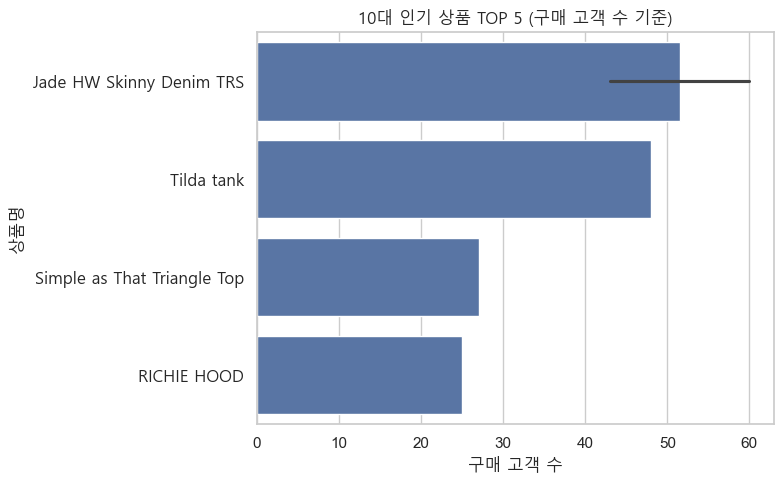

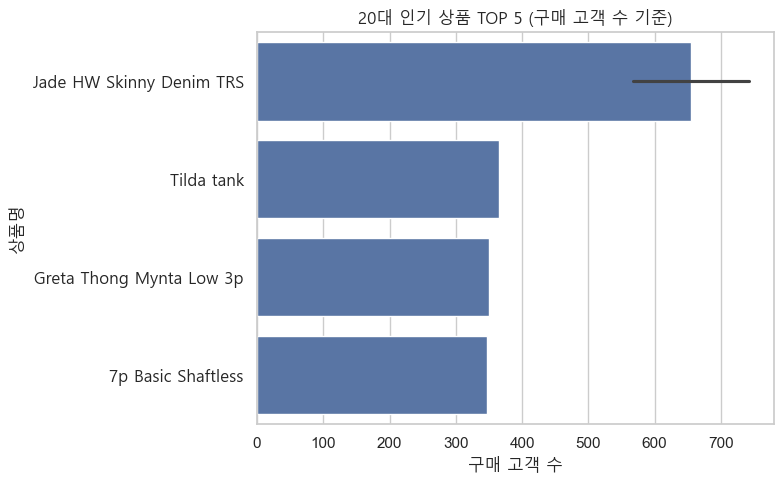

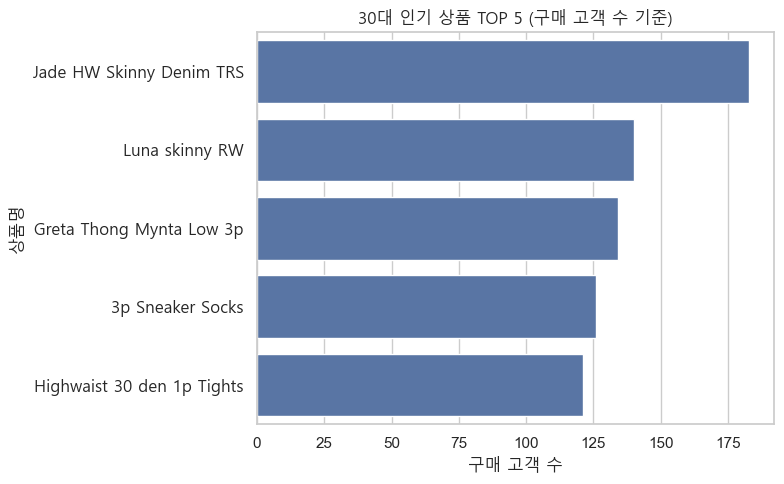

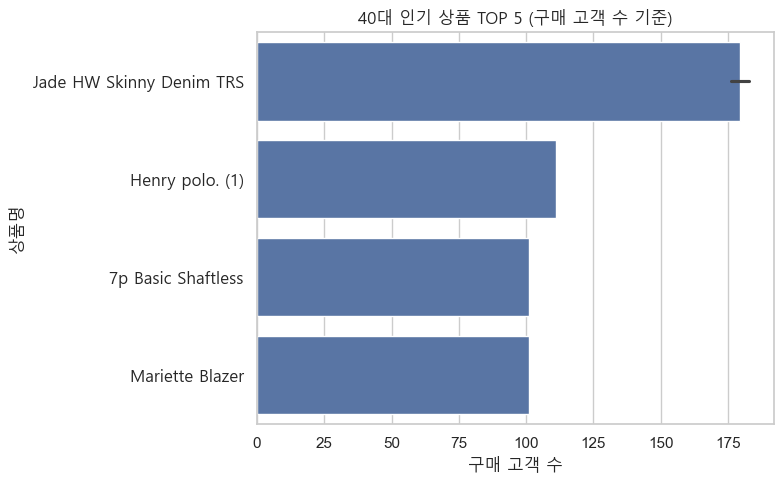

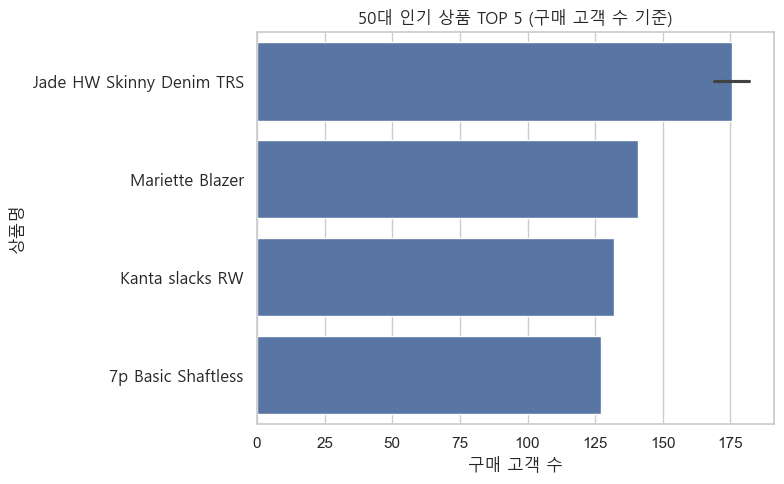

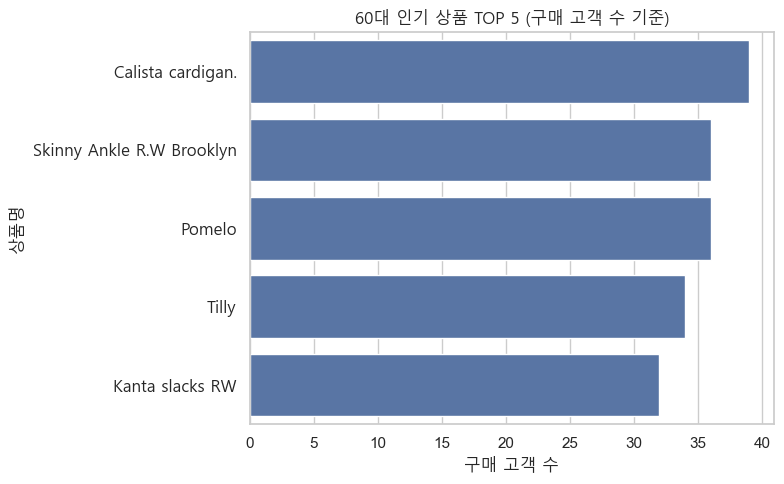

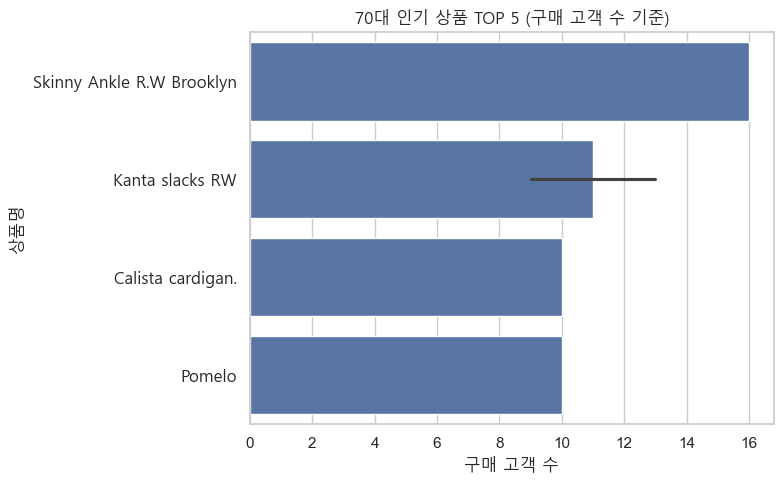

In [34]:
# 시각화할 연령대 (80, 90 제외)
plot_ages = [10, 20, 30, 40, 50, 60, 70]

for age in plot_ages:
    temp = top5_with_info[top5_with_info["age_group"] == age]
    if temp.empty:
        continue

    plt.figure(figsize=(8, 5))

    sns.barplot(
        data=temp,
        x="unique_customer_cnt",
        y="prod_name"
    )

    plt.title(f"{age}대 인기 상품 TOP 5 (구매 고객 수 기준)", fontproperties=font)
    plt.xlabel("구매 고객 수", fontproperties=font)
    plt.ylabel("상품명", fontproperties=font)

    # y축 상품명에도 폰트 적용
    plt.yticks(fontproperties=font)

    plt.tight_layout()
    plt.show()


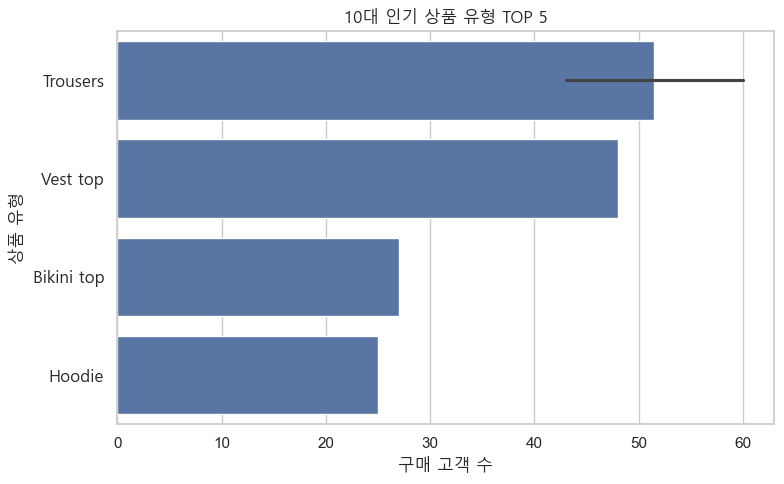

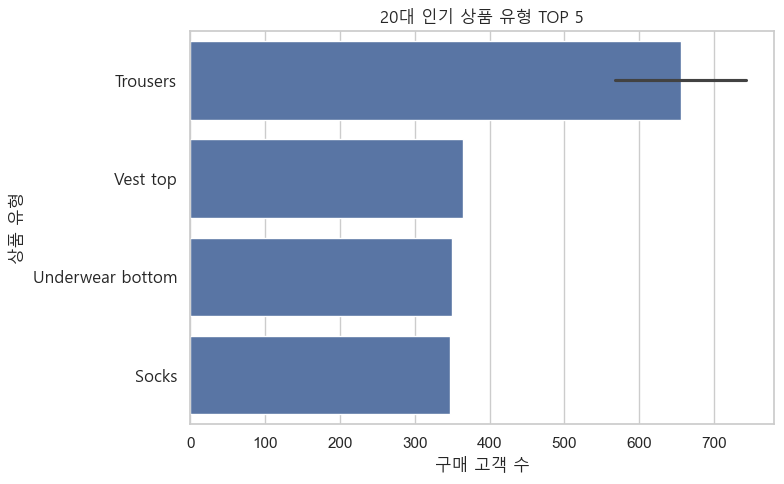

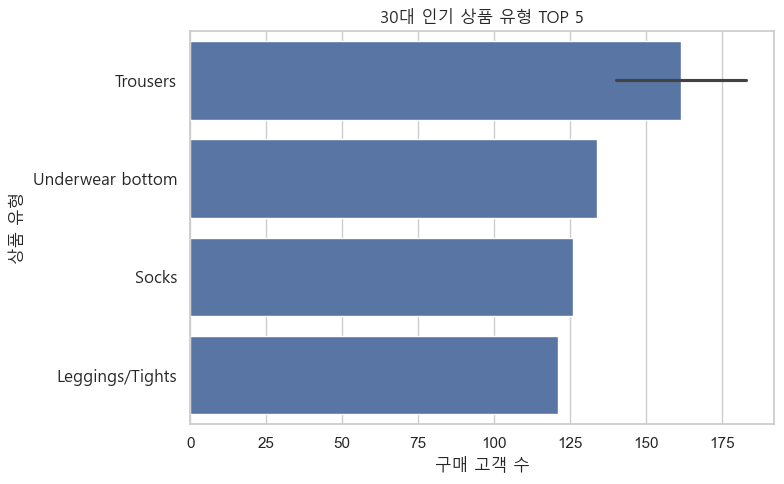

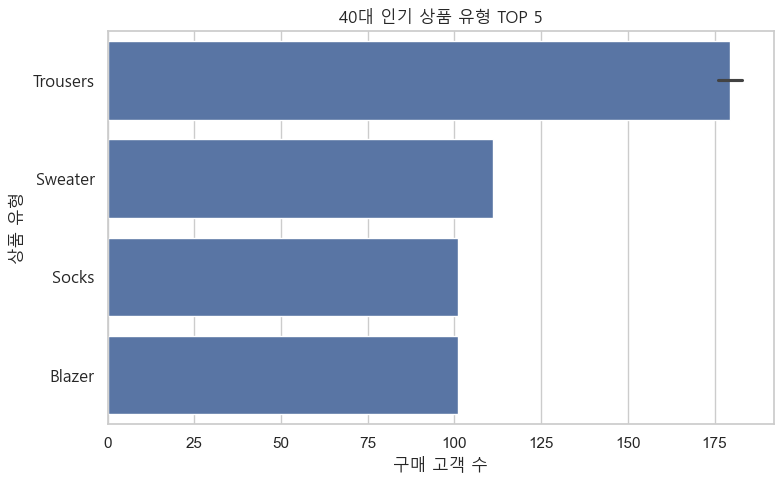

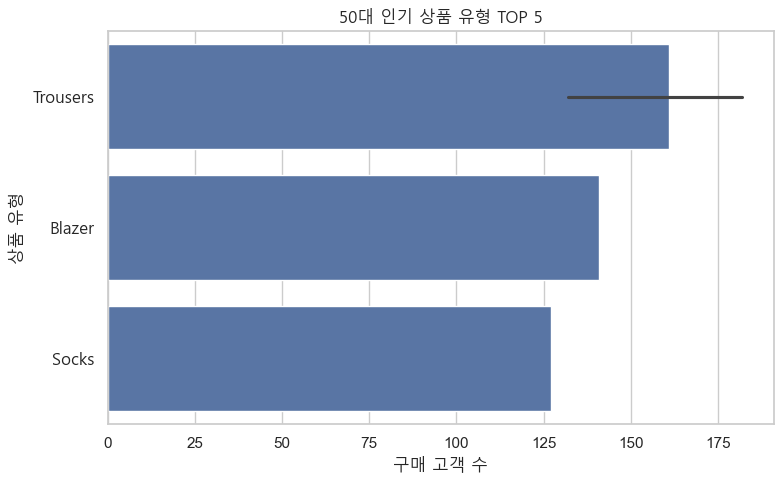

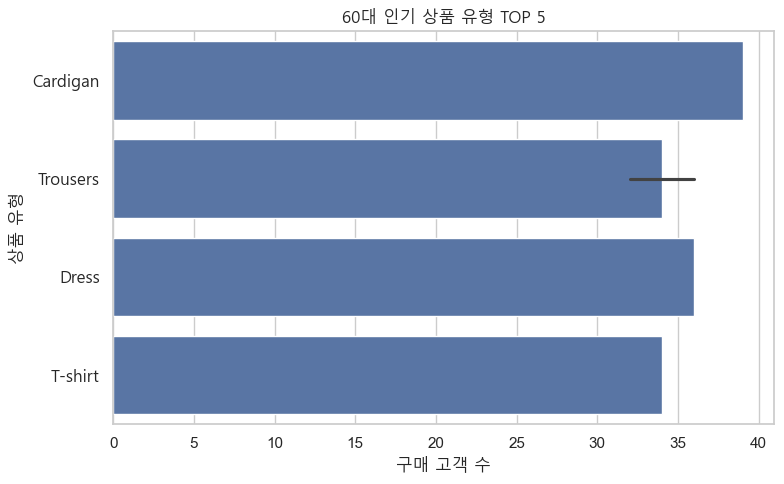

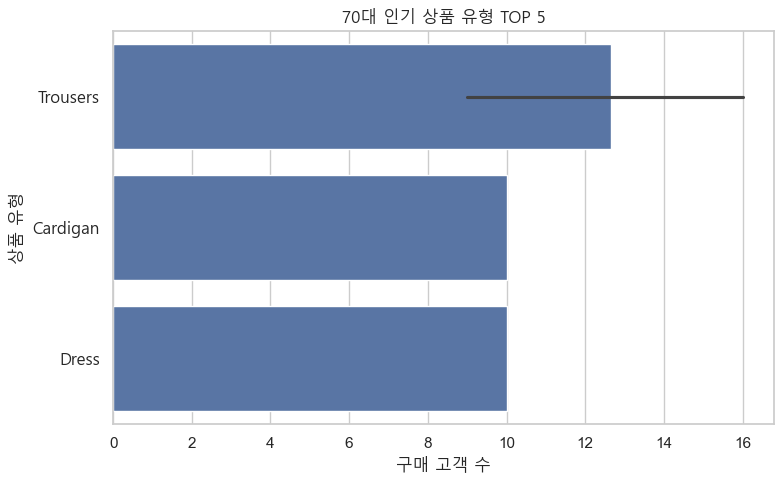

In [35]:
plot_ages = [10, 20, 30, 40, 50, 60, 70]  # 필요 없는 80, 90 제외

for age in plot_ages:
    temp = top5_with_info[top5_with_info["age_group"] == age]
    if temp.empty:
        continue

    plt.figure(figsize=(8, 5))

    sns.barplot(
        data=temp,
        x="unique_customer_cnt",
        y="product_type_name"
    )

    plt.title(f"{age}대 인기 상품 유형 TOP 5", fontproperties=font)
    plt.xlabel("구매 고객 수", fontproperties=font)
    plt.ylabel("상품 유형", fontproperties=font)

    plt.yticks(fontproperties=font)
    plt.tight_layout()
    plt.show()


# 연령별 총 매출액 상품 top5

In [36]:
# 1️⃣ 연령대별 · 상품별 총매출액 계산
age_article_sales = (
    df
    .groupby(['age_group', 'article_id'])['price']
    .sum()
    .reset_index(name='total_sales')
)

# 2️⃣ 연령대별 총매출액 기준 TOP 5 상품 선택
top5_articles_by_age_sales = (
    age_article_sales
    .sort_values(['age_group', 'total_sales'], ascending=[True, False])
    .groupby('age_group')
    .head(5)
)

# 3️⃣ 보기 좋게 출력
top5_articles_by_age_sales.reset_index(drop=True, inplace=True)

for age in sorted(top5_articles_by_age_sales['age_group'].unique()):
    temp = top5_articles_by_age_sales[top5_articles_by_age_sales['age_group'] == age]
    print(f"\n=== {age}대 매출 TOP 5 상품 ===")
    print(temp[['article_id', 'total_sales']].reset_index(drop=True))



=== 10대 매출 TOP 5 상품 ===
   article_id  total_sales
0   706016001     1.945881
1   706016002     1.391881
2   568601006     0.952729
3   706016003     0.823814
4   706016006     0.818898

=== 20대 매출 TOP 5 상품 ===
   article_id  total_sales
0   706016001    24.869509
1   706016002    18.786220
2   448509014    11.010288
3   706016003    10.722966
4   568601006    10.689847

=== 30대 매출 TOP 5 상품 ===
   article_id  total_sales
0   706016001     5.980593
1   730683001     4.295542
2   706016002     4.074932
3   790006001     4.019864
4   562245046     3.930881

=== 40대 매출 TOP 5 상품 ===
   article_id  total_sales
0   706016001     6.160898
1   706016002     5.989000
2   568601006     4.915983
3   706016003     3.166119
4   399061008     3.029102

=== 50대 매출 TOP 5 상품 ===
   article_id  total_sales
0   568601006     7.035424
1   706016001     6.038424
2   706016002     5.672814
3   687704001     3.425203
4   573716012     3.218288

=== 60대 매출 TOP 5 상품 ===
   article_id  total_sales
0   702790004

In [37]:
age_order = [10, 20, 30, 40, 50, 60, 70]

for age in age_order:
    temp = top5_product_by_age[top5_product_by_age["age_group"] == age]
    if temp.empty:
        continue

    print(f"\n=== {age}대 매출 TOP 5 상품 유형 ===")
    display(
        temp[['product_type_name', 'total_sales']]
        .reset_index(drop=True)
    )


NameError: name 'top5_product_by_age' is not defined

In [38]:
age_product_sales = (
    df
    .groupby(['age_group', 'product_type_name'])['price']
    .sum()
    .reset_index(name='total_sales')
)

top5_product_by_age = (
    age_product_sales
    .sort_values(['age_group', 'total_sales'], ascending=[True, False])
    .groupby('age_group')
    .head(5)
)


In [39]:
# 중복 제거
product_type_info = (
    articles[
        ['product_type_name', 'index_name', 'department_name']
    ]
    .drop_duplicates(subset='product_type_name')
)


In [40]:
# top5_product_by_age에 분류 정보 붙이기
top5_product_by_age = top5_product_by_age.merge(
    product_type_info,
    on='product_type_name',
    how='left'
)

In [41]:
age_order = [10, 20, 30, 40, 50, 60, 70]

for age in age_order:
    temp = top5_product_by_age[top5_product_by_age["age_group"] == age]
    if temp.empty:
        continue

    print(f"\n=== {age}대 매출 TOP 5 상품 유형 ===")
    display(
        temp[
            [
                'product_type_name',   # 상품 유형
                'index_name',          # 중분류명
                'department_name',     # 소분류명
                'total_sales'          # 총매출
            ]
        ].reset_index(drop=True)
    )



=== 10대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,total_sales
0,Trousers,Menswear,Jersey Basic,51.185661
1,Sweater,Baby Sizes 50-98,Baby basics,35.446085
2,Dress,Divided,Tops Knitwear DS,29.504068
3,Bikini top,Lingeries/Tights,Swimwear,17.423831
4,Bra,Lingeries/Tights,Clean Lingerie,15.687949



=== 20대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,total_sales
0,Trousers,Menswear,Jersey Basic,1392.900999
1,Dress,Divided,Tops Knitwear DS,1167.447321
2,Sweater,Baby Sizes 50-98,Baby basics,771.937287
3,Blouse,Divided,Projects Woven Tops,439.926085
4,Jacket,Sport,Men Sport Tops,370.261729



=== 30대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,total_sales
0,Trousers,Menswear,Jersey Basic,741.398508
1,Dress,Divided,Tops Knitwear DS,660.579169
2,Sweater,Baby Sizes 50-98,Baby basics,380.085355
3,Blouse,Divided,Projects Woven Tops,216.531034
4,Jacket,Sport,Men Sport Tops,197.959627



=== 40대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,total_sales
0,Trousers,Menswear,Jersey Basic,622.638237
1,Dress,Divided,Tops Knitwear DS,475.268830
2,Sweater,Baby Sizes 50-98,Baby basics,308.897542
3,Blouse,Divided,Projects Woven Tops,169.164322
4,Jacket,Sport,Men Sport Tops,155.895627



=== 50대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,total_sales
0,Trousers,Menswear,Jersey Basic,713.886796
1,Dress,Divided,Tops Knitwear DS,544.690864
2,Sweater,Baby Sizes 50-98,Baby basics,386.649338
3,Blouse,Divided,Projects Woven Tops,235.973322
4,Jacket,Sport,Men Sport Tops,176.840000



=== 60대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,total_sales
0,Trousers,Menswear,Jersey Basic,181.946508
1,Dress,Divided,Tops Knitwear DS,136.042000
2,Sweater,Baby Sizes 50-98,Baby basics,112.311271
3,Blouse,Divided,Projects Woven Tops,64.528458
4,Jacket,Sport,Men Sport Tops,50.993254



=== 70대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,total_sales
0,Trousers,Menswear,Jersey Basic,32.806797
1,Sweater,Baby Sizes 50-98,Baby basics,23.664085
2,Dress,Divided,Tops Knitwear DS,20.587322
3,Blouse,Divided,Projects Woven Tops,13.012034
4,Jacket,Sport,Men Sport Tops,9.991441


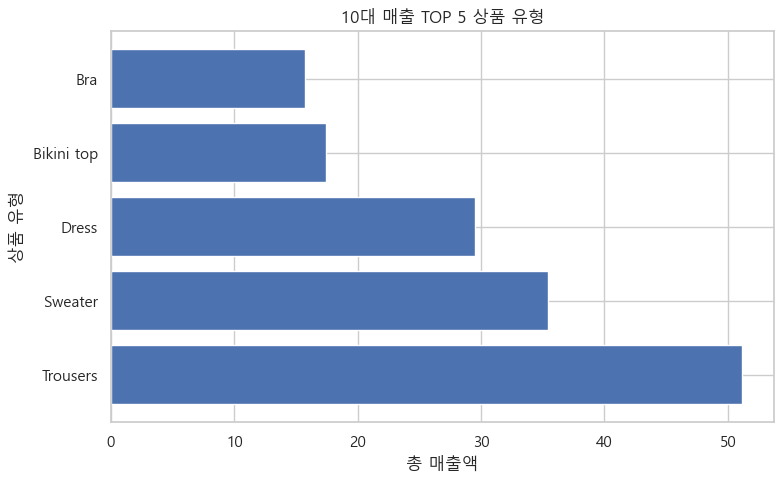

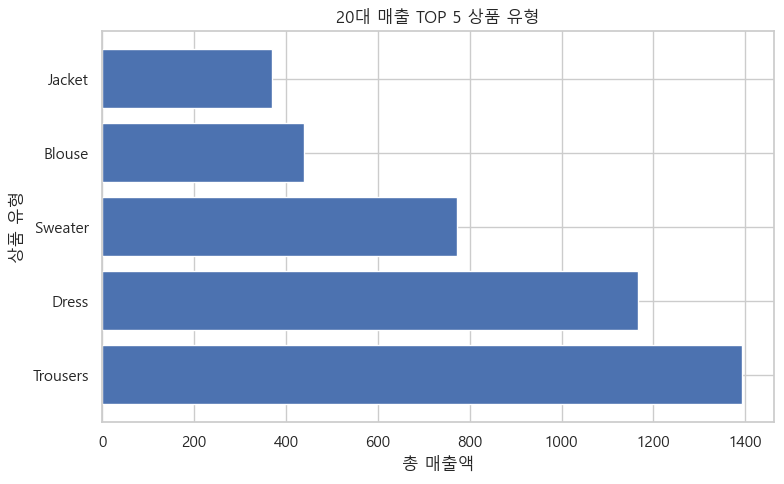

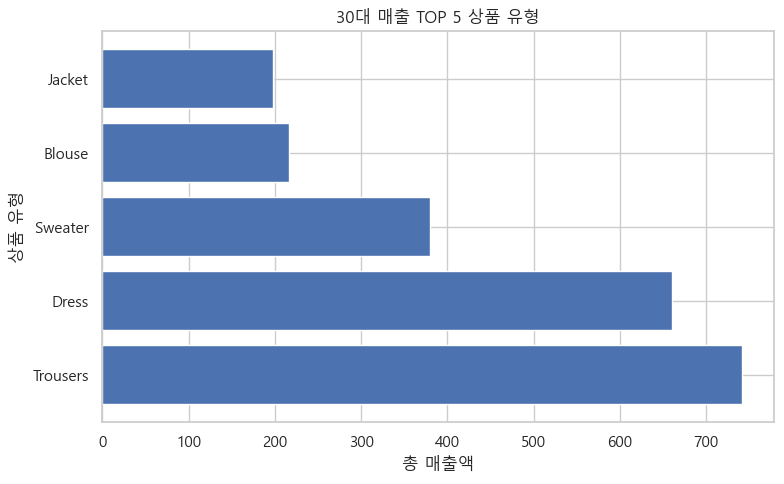

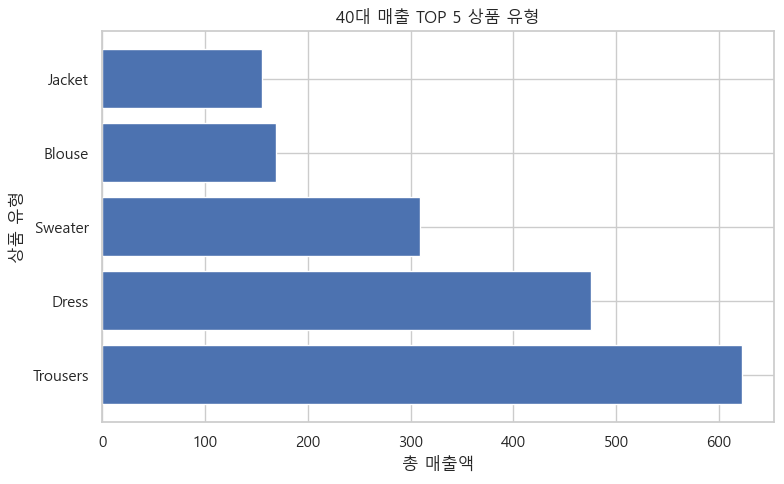

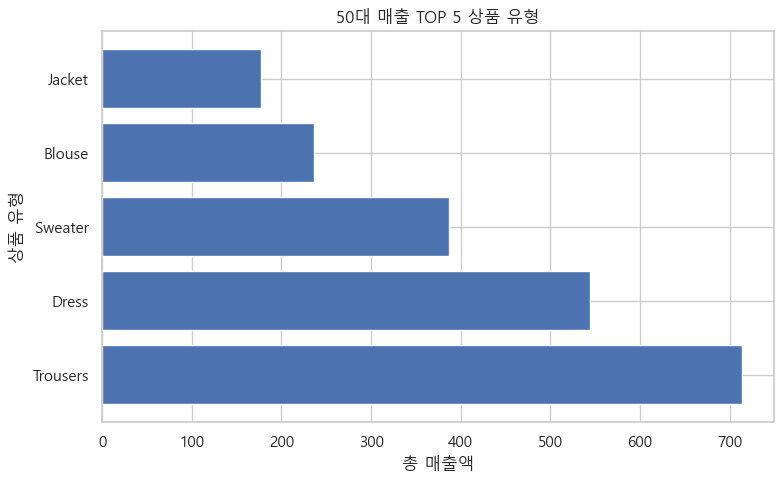

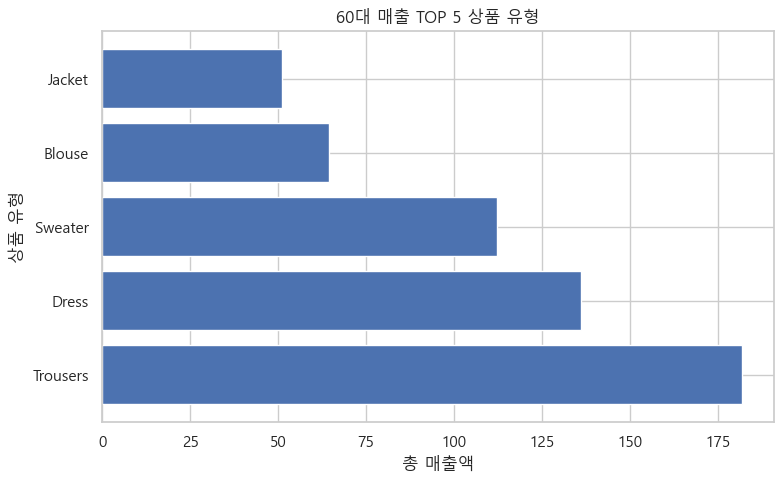

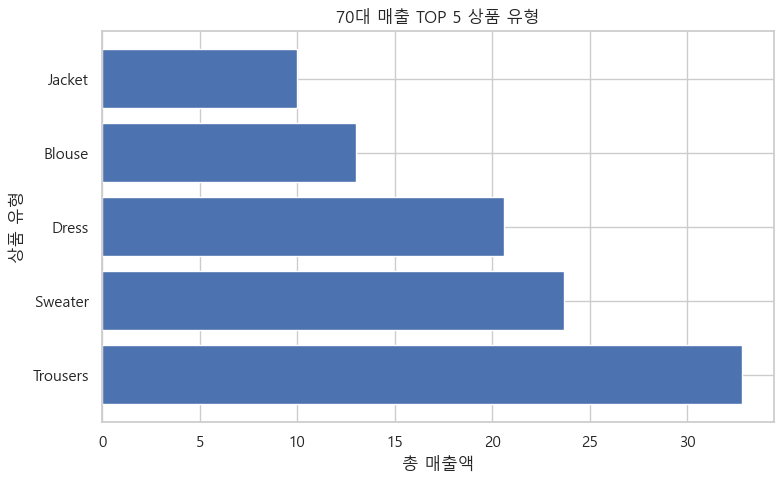

In [42]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

ages_to_plot = [10, 20, 30, 40, 50, 60, 70]

for age in ages_to_plot:
    temp = top5_product_by_age[top5_product_by_age["age_group"] == age]
    if temp.empty:
        continue

    plt.figure(figsize=(8, 5))
    plt.barh(
        temp["product_type_name"],
        temp["total_sales"]
    )
    plt.title(f"{age}대 매출 TOP 5 상품 유형")
    plt.xlabel("총 매출액")
    plt.ylabel("상품 유형")
    plt.tight_layout()
    plt.show()


# prod_name 포함 

In [43]:
type_product_sales = (
    df
    .groupby(['product_type_name', 'prod_name'])['price']
    .sum()
    .reset_index(name='product_sales')
)


In [44]:
top_product_per_type = (
    type_product_sales
    .sort_values(['product_type_name', 'product_sales'], ascending=[True, False])
    .groupby('product_type_name')
    .head(1)
)


In [45]:
top5_product_by_age = top5_product_by_age.merge(
    top_product_per_type[['product_type_name', 'prod_name']],
    on='product_type_name',
    how='left'
)


In [46]:
age_order = [10, 20, 30, 40, 50, 60, 70]

for age in age_order:
    temp = top5_product_by_age[top5_product_by_age["age_group"] == age]
    if temp.empty:
        continue

    print(f"\n=== {age}대 매출 TOP 5 상품 유형 ===")
    display(
        temp[
            [
                'product_type_name',   # 상품 유형
                'index_name',          # 중분류
                'department_name',     # 소분류
                'prod_name',           # 대표 상품명
                'total_sales'          # 총매출
            ]
        ].reset_index(drop=True)
    )



=== 10대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,prod_name,total_sales
0,Trousers,Menswear,Jersey Basic,Jade HW Skinny Denim TRS,51.185661
1,Sweater,Baby Sizes 50-98,Baby basics,Cinderella fold,35.446085
2,Dress,Divided,Tops Knitwear DS,Sorrel(1),29.504068
3,Bikini top,Lingeries/Tights,Swimwear,Simple as That Triangle Top,17.423831
4,Bra,Lingeries/Tights,Clean Lingerie,Hazelnut Push Melbourne,15.687949



=== 20대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,prod_name,total_sales
0,Trousers,Menswear,Jersey Basic,Jade HW Skinny Denim TRS,1392.900999
1,Dress,Divided,Tops Knitwear DS,Sorrel(1),1167.447321
2,Sweater,Baby Sizes 50-98,Baby basics,Cinderella fold,771.937287
3,Blouse,Divided,Projects Woven Tops,Despacito,439.926085
4,Jacket,Sport,Men Sport Tops,L Lilo Pile Coat,370.261729



=== 30대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,prod_name,total_sales
0,Trousers,Menswear,Jersey Basic,Jade HW Skinny Denim TRS,741.398508
1,Dress,Divided,Tops Knitwear DS,Sorrel(1),660.579169
2,Sweater,Baby Sizes 50-98,Baby basics,Cinderella fold,380.085355
3,Blouse,Divided,Projects Woven Tops,Despacito,216.531034
4,Jacket,Sport,Men Sport Tops,L Lilo Pile Coat,197.959627



=== 40대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,prod_name,total_sales
0,Trousers,Menswear,Jersey Basic,Jade HW Skinny Denim TRS,622.638237
1,Dress,Divided,Tops Knitwear DS,Sorrel(1),475.268830
2,Sweater,Baby Sizes 50-98,Baby basics,Cinderella fold,308.897542
3,Blouse,Divided,Projects Woven Tops,Despacito,169.164322
4,Jacket,Sport,Men Sport Tops,L Lilo Pile Coat,155.895627



=== 50대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,prod_name,total_sales
0,Trousers,Menswear,Jersey Basic,Jade HW Skinny Denim TRS,713.886796
1,Dress,Divided,Tops Knitwear DS,Sorrel(1),544.690864
2,Sweater,Baby Sizes 50-98,Baby basics,Cinderella fold,386.649338
3,Blouse,Divided,Projects Woven Tops,Despacito,235.973322
4,Jacket,Sport,Men Sport Tops,L Lilo Pile Coat,176.840000



=== 60대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,prod_name,total_sales
0,Trousers,Menswear,Jersey Basic,Jade HW Skinny Denim TRS,181.946508
1,Dress,Divided,Tops Knitwear DS,Sorrel(1),136.042000
2,Sweater,Baby Sizes 50-98,Baby basics,Cinderella fold,112.311271
3,Blouse,Divided,Projects Woven Tops,Despacito,64.528458
4,Jacket,Sport,Men Sport Tops,L Lilo Pile Coat,50.993254



=== 70대 매출 TOP 5 상품 유형 ===


,product_type_name,index_name,department_name,prod_name,total_sales
0,Trousers,Menswear,Jersey Basic,Jade HW Skinny Denim TRS,32.806797
1,Sweater,Baby Sizes 50-98,Baby basics,Cinderella fold,23.664085
2,Dress,Divided,Tops Knitwear DS,Sorrel(1),20.587322
3,Blouse,Divided,Projects Woven Tops,Despacito,13.012034
4,Jacket,Sport,Men Sport Tops,L Lilo Pile Coat,9.991441


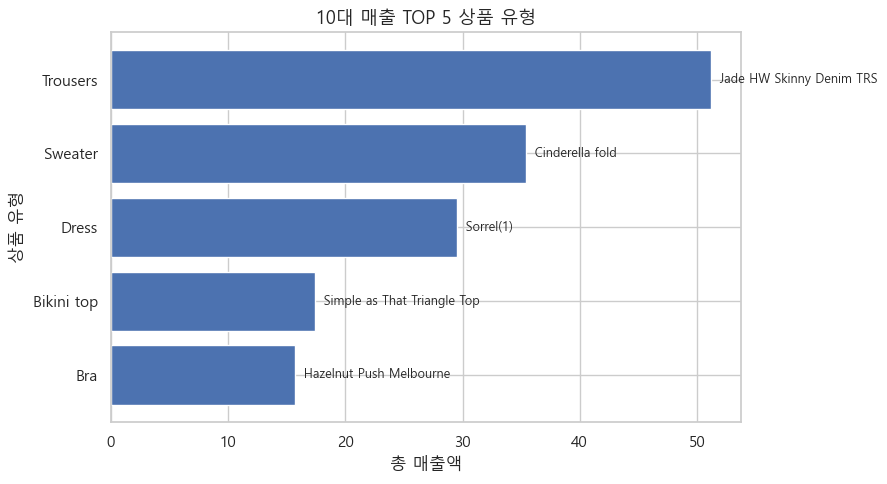

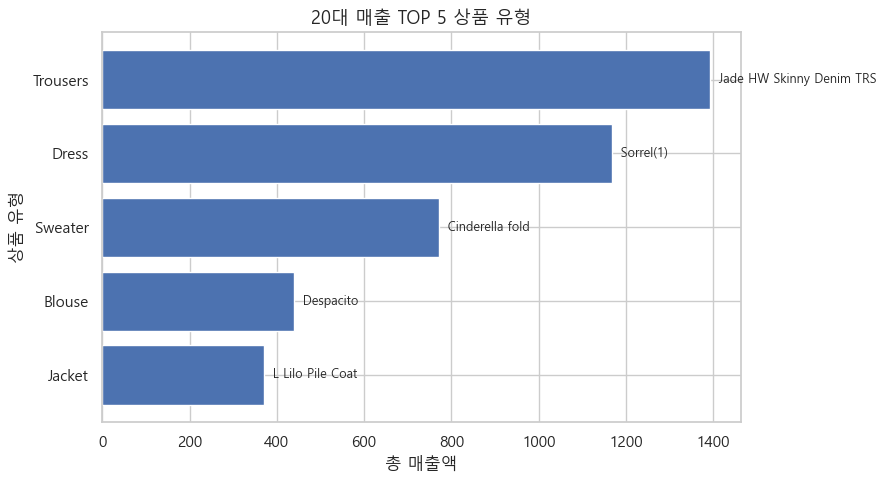

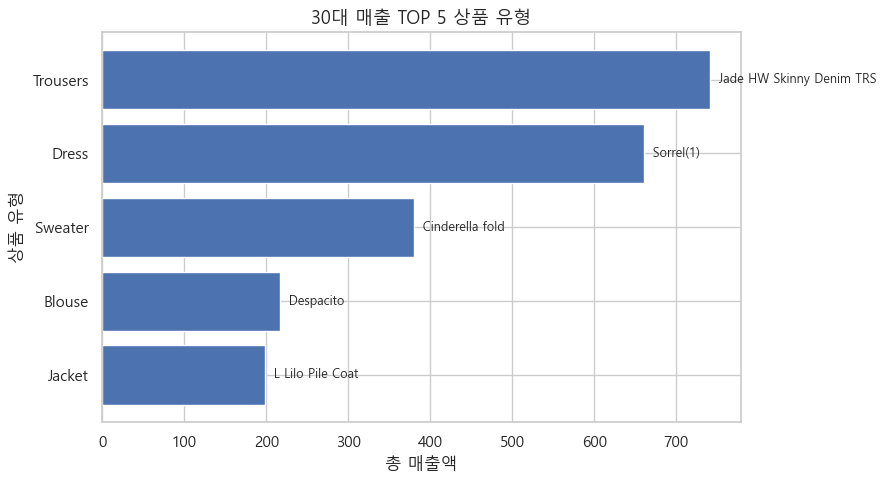

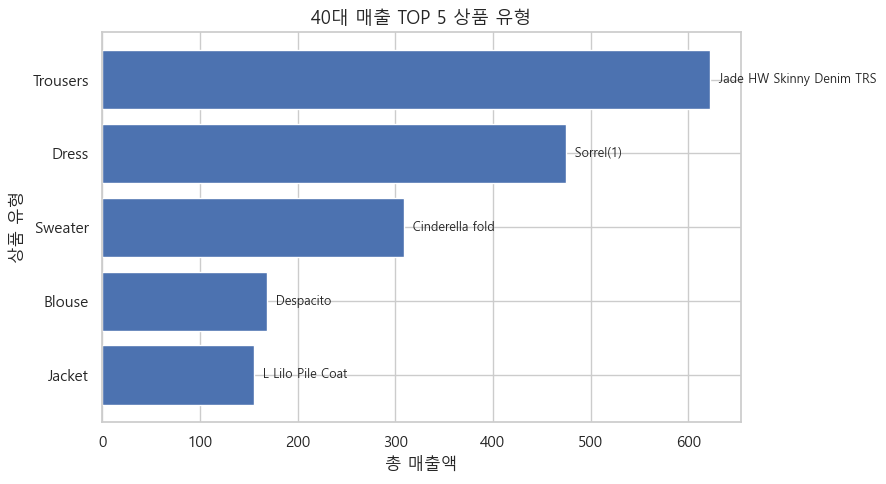

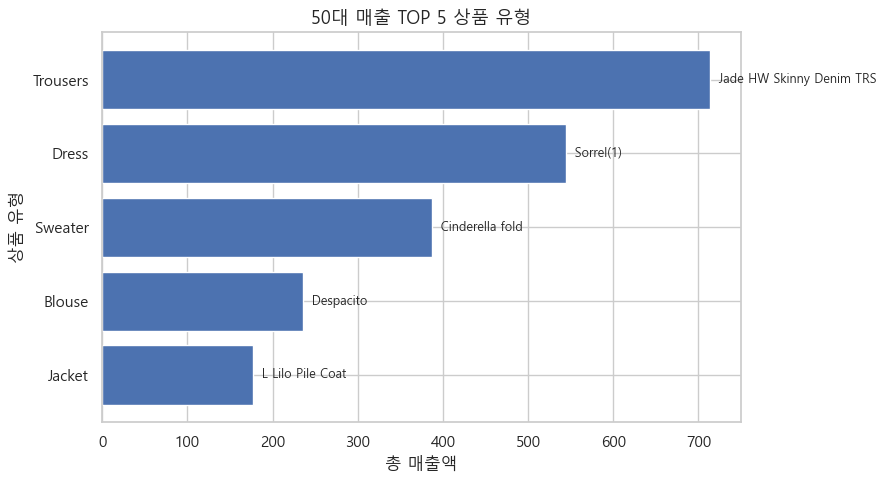

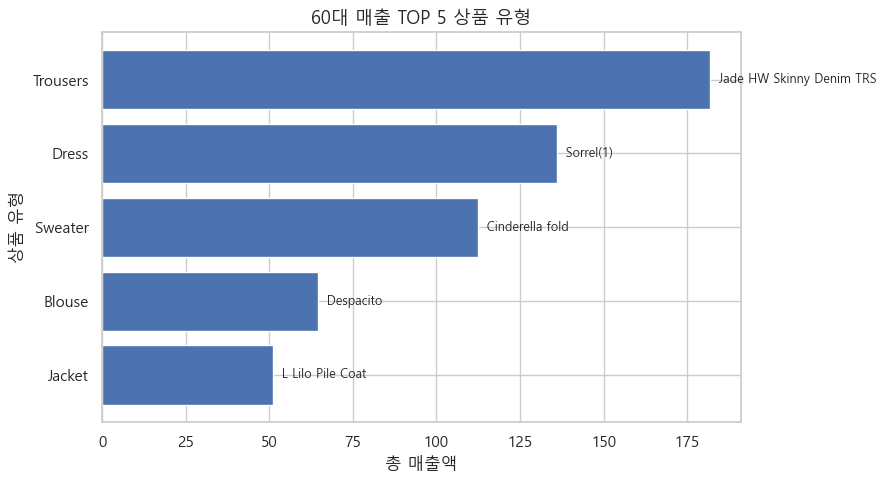

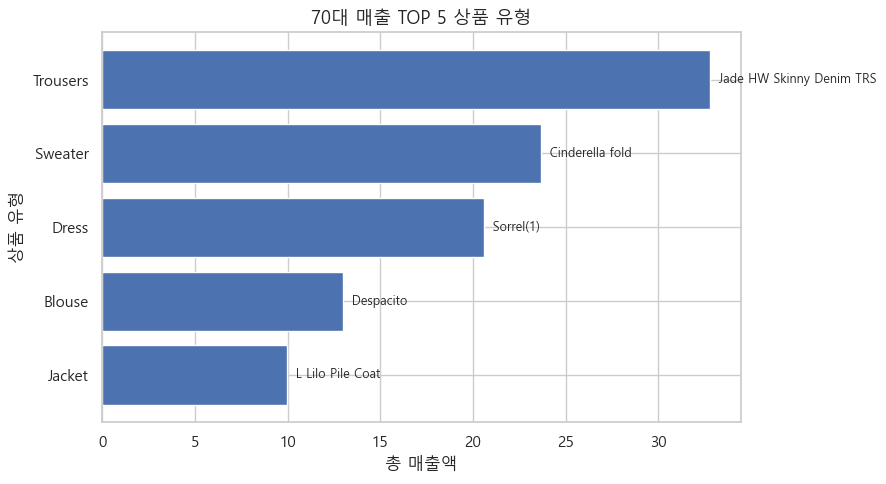

In [47]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"   # Windows
plt.rcParams["axes.unicode_minus"] = False

ages_to_plot = [10, 20, 30, 40, 50, 60, 70]

for age in ages_to_plot:
    temp = top5_product_by_age[top5_product_by_age["age_group"] == age]
    if temp.empty:
        continue

    # 보기 좋게 정렬 (아래 → 위로 크게)
    temp = temp.sort_values("total_sales")

    plt.figure(figsize=(9, 5))
    bars = plt.barh(
        temp["product_type_name"],
        temp["total_sales"]
    )

    # 막대 옆에 대표 상품명 표시
    for bar, prod in zip(bars, temp["prod_name"]):
        plt.text(
            bar.get_width(),
            bar.get_y() + bar.get_height()/2,
            f"  {prod}",
            va="center",
            fontsize=9
        )

    plt.title(f"{age}대 매출 TOP 5 상품 유형", fontsize=13)
    plt.xlabel("총 매출액")
    plt.ylabel("상품 유형")
    plt.tight_layout()
    plt.show()
